https://github.com/makcedward/nlpaug#installation

In [ ]:
access_token = ""

In [2]:
idCuda = "3, 4, 5"
idTorch = 0

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{str(idCuda)}"

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, default_data_collator, EarlyStoppingCallback, IntervalStrategy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score # Import all needed metrics
#from torch.utils.data import DataLoader, Dataset

In [5]:
torch.cuda.device_count()

3

In [6]:
torch.cuda.empty_cache()
torch.cuda.set_device(idTorch)

if torch.cuda.is_available():
    GPU = torch.cuda.get_device_name(idTorch)
    print(f"PyTorch available GPU: {GPU}")
else:
    print("GPU not available")

PyTorch available GPU: NVIDIA RTX A6000


In [7]:
device = torch.device(f"cuda:{idTorch}" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

Device: cuda:0


In [8]:
topicos = True
fiveOrTree = False
classes = 3
classCol = 'sentiment'
if fiveOrTree:
    classes = 5
    classCol = 'scoreSA'

In [9]:
test_size = 0.2
locationOriginalDataset = '/home/patrick.araujo/topicModeling/trainTesting/export_outS_AmazonAutoRO_3_classeALL.csv'
print(f'Usando para o cojunto de teste {100-test_size*100}% e validação {test_size*100}% de:  "{locationOriginalDataset}"')
dataset = pd.read_csv(locationOriginalDataset)

Usando para o cojunto de teste 80.0% e validação 20.0% de:  "/home/patrick.araujo/topicModeling/trainTesting/export_outS_AmazonAutoRO_3_classeALL.csv"


In [10]:
dataset

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,7339,7608.0,11121.0,17630,Donna Brown,https://play-lh.googleusercontent.com/a/ACg8oc...,It was simple to access once I figured it out.,5,0.0,26.21.0.100,2023-10-29 18:59:35,NaN,NaN,26.21.0.100,2,46,en,4,"['app', 'amazon', 'love', 'great', 'need', 'go..."
1,11432,11843.0,17077.0,17283,Rene Cesar,https://play-lh.googleusercontent.com/a-/ALV-U...,Besides finding almost everything on here it's...,2,4.0,26.9.0.100,2023-04-28 22:48:57,NaN,NaN,26.9.0.100,0,463,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
2,240,NaN,NaN,9682,NaN,NaN,"i have to go with android settings, then upgra...",3,NaN,NaN,NaN,NaN,NaN,NaN,1,218,NaN,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
3,10173,10543.0,15523.0,3230,Michecoe Cole,https://play-lh.googleusercontent.com/a/ACg8oc...,I ordered a package on the 26th and it said it...,2,1.0,26.13.6.100,2023-06-29 12:32:45,NaN,NaN,26.13.6.100,0,215,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
4,9327,9655.0,14390.0,13462,Aaron Lamb,https://play-lh.googleusercontent.com/a/ACg8oc...,DON'T UPGRADE! Even...slower...still... Why di...,2,4.0,26.15.0.100,2023-08-10 12:58:47,NaN,NaN,26.15.0.100,0,441,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24067,4158,4322.0,6304.0,5955,Katie Barlow,https://play-lh.googleusercontent.com/a-/ALV-U...,"Doesn't work after update. Crashes, freezes, c...",1,0.0,24.8.0.100,2023-11-23 17:24:17,NaN,NaN,24.8.0.100,0,169,en,0,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
24068,10313,10685.0,15697.0,9792,Kyle S,https://play-lh.googleusercontent.com/a-/ALV-U...,Poor UI Design Choice The search bar is now fi...,3,30.0,26.13.0.100,2023-06-23 10:03:46,NaN,NaN,26.13.0.100,1,269,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
24069,3414,NaN,NaN,23376,NaN,NaN,my amazon watch app is back when me'm in their...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,68,NaN,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
24070,16458,17039.0,24319.0,15523,Laurie KELSEY Myers,https://play-lh.googleusercontent.com/a/ACg8oc...,You MUST ENSURE I R receiving FREE SHIPPING U ...,3,2.0,24.10.2.100,2022-06-01 13:39:14,NaN,NaN,24.10.2.100,1,339,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."


In [11]:
dataset.shape

(24072, 19)

In [12]:
score_counts_balanced = dataset['scoreSA'].value_counts().sort_index()
print(score_counts_balanced)

scoreSA
0    3723
1    4301
2    8024
3    4530
4    3494
Name: count, dtype: int64


In [13]:
sentiments_counts_balanced = dataset['sentiment'].value_counts().sort_index()
print(sentiments_counts_balanced)

sentiment
0    8024
1    8024
2    8024
Name: count, dtype: int64


In [14]:
generated_RO = dataset[dataset['index'].isna()]
df_original = dataset[~dataset['index'].isna()]

score_dfO_counts_balanced = df_original[classCol].value_counts().sort_index()
highest_count = score_dfO_counts_balanced.max()
highest_value = score_dfO_counts_balanced[score_dfO_counts_balanced == highest_count].index[0]

In [15]:
train_data_AllC = None
val_data_AllC = None

df_filtered_scMAX = df_original[df_original[classCol] == highest_value].reset_index(drop=True)
train_dataMAX, val_dataMAX = train_test_split(df_filtered_scMAX, test_size=test_size, random_state=42)

all_dfs_Train = []
all_dfs_Val = []

all_dfs_Train.append(train_dataMAX)
all_dfs_Val.append(val_dataMAX)

for score_value, count in score_dfO_counts_balanced.items():
    if (highest_value != score_value):
        df_filtered_scTemp = df_original[df_original[classCol] == score_value].reset_index(drop=True)
        train_dataTemp, val_dataTemp = train_test_split(df_filtered_scTemp, test_size=len(val_dataMAX), train_size=None, random_state=42)
        remainingGenRO = generated_RO[generated_RO[classCol] == score_value].reset_index(drop=True)
        merged_df = pd.concat([remainingGenRO, train_dataTemp])
        merged_df = merged_df.reset_index(drop=True)
        merged_df = merged_df.sample(frac=1)
        val_dataTemp = val_dataTemp.sample(frac=1)
        all_dfs_Train.append(merged_df)
        all_dfs_Val.append(val_dataTemp)
combined_df_Train = pd.concat(all_dfs_Train, ignore_index=True)
combined_df_Train = combined_df_Train.sample(frac=1)
train_data_AllC = combined_df_Train.reset_index(drop=True)
combined_df_Val = pd.concat(all_dfs_Val, ignore_index=True)
combined_df_Val = combined_df_Val.sample(frac=1)
val_data_AllC = combined_df_Val.reset_index(drop=True)

In [16]:
train_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,5335,5556.0,8278.0,768,Asmaa Nagy,https://play-lh.googleusercontent.com/a/ACg8oc...,worst company ever not just the app,1,0.0,NaN,2023-11-11 04:18:47,NaN,NaN,NaN,0,35,en,0,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
1,2995,NaN,NaN,8169,NaN,NaN,new update focuses more on the ads for their s...,3,NaN,NaN,NaN,NaN,NaN,NaN,1,155,NaN,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
2,10633,11010.0,16086.0,19237,Natasha Rainey,https://play-lh.googleusercontent.com/a-/ALV-U...,The latest update is super annoying. Moving th...,3,2.0,26.12.0.100,2023-06-12 08:10:23,NaN,NaN,26.12.0.100,1,202,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
3,4970,5175.0,7631.0,22124,L P,https://play-lh.googleusercontent.com/a-/ALV-U...,"Hey everyone, for a functional wishlist that c...",1,4.0,26.21.0.100,2023-11-15 12:15:57,NaN,NaN,26.21.0.100,0,172,en,0,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
4,3252,3366.0,4884.0,20460,Marina Sanchez,https://play-lh.googleusercontent.com/a-/ALV-U...,I lost the keys for the mail and the package g...,1,0.0,26.22.0.100,2023-12-03 16:33:30,NaN,NaN,26.22.0.100,0,101,en,0,"['app', 'amazon', 'just', 'don', 'search', 'ti..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19252,836,860.0,1311.0,10918,Trevor Riley,https://play-lh.googleusercontent.com/a/ACg8oc...,"constant issues with delivery drivers, always ...",3,0.0,26.23.4.100,2023-12-30 11:37:34,NaN,NaN,26.23.4.100,1,95,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
19253,8889,9198.0,13813.0,18981,Katie Westphal,https://play-lh.googleusercontent.com/a/ACg8oc...,It took so long to load it was almost a hour t...,3,0.0,26.16.0.100,2023-09-03 01:13:38,NaN,NaN,26.16.0.100,1,100,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
19254,8717,9018.0,13572.0,21465,Umar Faruk Abubakar,https://play-lh.googleusercontent.com/a/ACg8oc...,Every time I tried entering Amazon pay but I c...,2,0.0,26.16.0.100,2023-09-15 04:29:59,NaN,NaN,26.16.0.100,0,128,en,1,"['app', 'amazon', 'just', 'search', 'update', ..."
19255,675,NaN,NaN,11669,NaN,NaN,"software v / g, but capable for using software...",4,NaN,NaN,NaN,NaN,NaN,NaN,2,56,NaN,3,"['amazon', 'app', 'shopping', 'love', 'great',..."


In [17]:
val_data_AllC

,level_0,index,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,sentiment,lengthContent,Language,scoreSA,topics
0,5655,5896.0,8810.0,6942,Danielle Evans,https://play-lh.googleusercontent.com/a/ACg8oc...,Have used for years. Barely any hiccups along ...,5,0.0,26.21.0.100,2023-11-07 19:13:22,NaN,NaN,26.21.0.100,2,89,en,4,"['glitches', 'years barely hiccups', 'hiccups ..."
1,9741,10089.0,14949.0,5487,Rachel Doehass,https://play-lh.googleusercontent.com/a-/ALV-U...,What is it with apps changing the search bar t...,4,0.0,26.13.6.100,2023-07-19 22:50:39,NaN,NaN,26.13.6.100,2,97,en,3,"['app', 'amazon', 'love', 'great', 'need', 'go..."
2,9033,9346.0,13995.0,20171,Dan Barrett,https://play-lh.googleusercontent.com/a/ACg8oc...,Great app but lacks as it has no dark mode. So...,3,0.0,NaN,2023-08-25 18:02:03,NaN,NaN,NaN,1,117,en,2,"['app', 'amazon', 'just', 'like', 'don', 'time..."
3,16120,16687.0,23745.0,13900,Doris Clark,https://play-lh.googleusercontent.com/a/ACg8oc...,Wish i could keep the same bowling ball for an...,3,0.0,NaN,2022-06-18 16:12:34,NaN,NaN,NaN,1,88,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
4,16274,16846.0,24001.0,21287,Michael Osborne (MoMo),https://play-lh.googleusercontent.com/a/ACg8oc...,"Good app, but it's very slow to load items, pa...",4,0.0,24.11.0.100,2022-06-11 11:46:35,NaN,NaN,24.11.0.100,2,62,en,3,"['amazon', 'app', 'shopping', 'love', 'great',..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4810,16208,16778.0,23889.0,11992,darrell hadnot,https://play-lh.googleusercontent.com/a/ACg8oc...,"Great experience, lots of items, free shipping...",4,1.0,24.11.0.100,2022-06-13 17:28:22,NaN,NaN,24.11.0.100,2,74,en,3,"['experience lots', 'items free', 'trips highl..."
4811,12214,12651.0,18125.0,12279,Gerald Healey,https://play-lh.googleusercontent.com/a/ACg8oc...,The app is good when it's working. It's fast a...,3,0.0,24.22.0.100,2023-03-05 00:00:17,NaN,NaN,24.22.0.100,1,209,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
4812,15482,16028.0,22723.0,5641,Quinn,https://play-lh.googleusercontent.com/a-/ALV-U...,Love Amazon and how easy everything is but PLE...,3,0.0,24.13.0.100,2022-08-01 13:21:14,NaN,NaN,24.13.0.100,1,215,en,2,"['app', 'amazon', 'just', 'time', 'like', 'ord..."
4813,12307,12748.0,18244.0,13957,Richard Williams,https://play-lh.googleusercontent.com/a-/ALV-U...,Their deliveries are late every other delivery...,2,0.0,26.4.0.100,2023-02-26 15:55:35,NaN,NaN,26.4.0.100,0,179,en,1,"['app', 'amazon', 'just', 'don', 'search', 'ti..."


In [18]:
print(val_data_AllC[val_data_AllC['index'].isna()])

Empty DataFrame
Columns: [level_0, index, Unnamed: 0, reviewId, userName, userImage, content, score, thumbsUpCount, reviewCreatedVersion, at, replyContent, repliedAt, appVersion, sentiment, lengthContent, Language, scoreSA, topics]
Index: []


In [19]:
train_data = None
val_data = None

if topicos:
    train_data = train_data_AllC[['content', 'topics', classCol]]
    val_data = val_data_AllC[['content', 'topics', classCol]]
else:
    train_data = train_data_AllC[['content', classCol]]
    val_data = val_data_AllC[['content', classCol]]

In [20]:
# Load the pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5, token=access_token)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Move model to GPU
model = model.to(device)

Essa parte garante que os dados serão balanceados tanto para treino como para testagem

In [22]:
print("Training Data")
print(train_data[classCol].value_counts().sort_index())
print("\nValidation Data")
print(val_data[classCol].value_counts().sort_index())

Training Data
sentiment
0    6419
1    6419
2    6419
Name: count, dtype: int64

Validation Data
sentiment
0    1605
1    1605
2    1605
Name: count, dtype: int64


In [23]:
train_data

,content,topics,sentiment
0,worst company ever not just the app,"['app', 'amazon', 'just', 'don', 'search', 'ti...",0
1,new update focuses more on the ads for their s...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
2,The latest update is super annoying. Moving th...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
3,"Hey everyone, for a functional wishlist that c...","['app', 'amazon', 'just', 'don', 'search', 'ti...",0
4,I lost the keys for the mail and the package g...,"['app', 'amazon', 'just', 'don', 'search', 'ti...",0
...,...,...,...
19252,"constant issues with delivery drivers, always ...","['app', 'amazon', 'just', 'time', 'like', 'ord...",1
19253,It took so long to load it was almost a hour t...,"['app', 'amazon', 'just', 'like', 'don', 'time...",1
19254,Every time I tried entering Amazon pay but I c...,"['app', 'amazon', 'just', 'search', 'update', ...",0
19255,"software v / g, but capable for using software...","['amazon', 'app', 'shopping', 'love', 'great',...",2


In [24]:
val_data

,content,topics,sentiment
0,Have used for years. Barely any hiccups along ...,"['glitches', 'years barely hiccups', 'hiccups ...",2
1,What is it with apps changing the search bar t...,"['app', 'amazon', 'love', 'great', 'need', 'go...",2
2,Great app but lacks as it has no dark mode. So...,"['app', 'amazon', 'just', 'like', 'don', 'time...",1
3,Wish i could keep the same bowling ball for an...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
4,"Good app, but it's very slow to load items, pa...","['amazon', 'app', 'shopping', 'love', 'great',...",2
...,...,...,...
4810,"Great experience, lots of items, free shipping...","['experience lots', 'items free', 'trips highl...",2
4811,The app is good when it's working. It's fast a...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
4812,Love Amazon and how easy everything is but PLE...,"['app', 'amazon', 'just', 'time', 'like', 'ord...",1
4813,Their deliveries are late every other delivery...,"['app', 'amazon', 'just', 'don', 'search', 'ti...",0


In [25]:
max_length = 512

In [26]:
def tokenizerFunctionWithTopics(string, topics):
    # Tokenize using tokenizer function
    string_list = eval(topics)
    tokens = tokenizer.encode_plus(string, topics, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

def tokenizerFunction(string):
    # Tokenize without topics
    tokens = tokenizer(string, padding='max_length', truncation=True, max_length=max_length, return_tensors="pt")
    return tokens

# Assuming train_data and val_data are defined somewhere in your code
train_encodings = train_data['content'].apply(tokenizerFunction)
if topicos:
    train_encodings = train_data.apply(lambda x: tokenizerFunctionWithTopics(x['content'], x['topics']), axis=1)
val_encodings = val_data['content'].apply(tokenizerFunction)

In [27]:
train_encodings

0        [input_ids, token_type_ids, attention_mask]
1        [input_ids, token_type_ids, attention_mask]
2        [input_ids, token_type_ids, attention_mask]
3        [input_ids, token_type_ids, attention_mask]
4        [input_ids, token_type_ids, attention_mask]
                            ...                     
19252    [input_ids, token_type_ids, attention_mask]
19253    [input_ids, token_type_ids, attention_mask]
19254    [input_ids, token_type_ids, attention_mask]
19255    [input_ids, token_type_ids, attention_mask]
19256    [input_ids, token_type_ids, attention_mask]
Length: 19257, dtype: object

In [28]:
val_encodings

0       [input_ids, token_type_ids, attention_mask]
1       [input_ids, token_type_ids, attention_mask]
2       [input_ids, token_type_ids, attention_mask]
3       [input_ids, token_type_ids, attention_mask]
4       [input_ids, token_type_ids, attention_mask]
                           ...                     
4810    [input_ids, token_type_ids, attention_mask]
4811    [input_ids, token_type_ids, attention_mask]
4812    [input_ids, token_type_ids, attention_mask]
4813    [input_ids, token_type_ids, attention_mask]
4814    [input_ids, token_type_ids, attention_mask]
Name: content, Length: 4815, dtype: object

In [29]:
def creatingDataframe(encodings):
  indices = encodings.index.to_numpy()

  df = pd.DataFrame(columns=['input_ids', 'attention_mask'])
  
  # Assuming 'content' is a Series or List containing tuples/lists
  for element in encodings:
    input_ids = element['input_ids'][0].numpy()              # Replace with correct index based on your data structure
    attention_mask = element['attention_mask'][0].numpy()    # Replace with correct index
    df.loc[len(df.index)] = [input_ids, attention_mask]
  df_index = pd.DataFrame(indices, columns=['index'])
  df['index'] = df_index['index']
  return df

# Batch Size

In [30]:
# Define batch size and create data loaders
batch_size = 16  # Adjust as needed

In [31]:
# Create datasets
# Convert labels to tensors
train_dataset = creatingDataframe(train_encodings)
train_labels = train_data[classCol].reset_index(name='label')
train_dataset = pd.merge(train_dataset, train_labels, on='index')

val_dataset = creatingDataframe(val_encodings)
val_labels = val_data[classCol].reset_index(name='label')
val_dataset = pd.merge(val_dataset, val_labels, on='index')

In [32]:
train_dataset = train_dataset.drop('index', axis=1)
val_dataset = val_dataset.drop('index', axis=1)

In [33]:
train_dataset

,input_ids,attention_mask,label
0,"[101, 5409, 2194, 2412, 2025, 2074, 1996, 1043...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
1,"[101, 2047, 10651, 7679, 2062, 2006, 1996, 149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
2,"[101, 1996, 6745, 10651, 2003, 3565, 15703, 10...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,"[101, 4931, 3071, 1010, 2005, 1037, 8360, 4299...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
4,"[101, 1045, 2439, 1996, 6309, 2005, 1996, 5653...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
...,...,...,...
19252,"[101, 5377, 3314, 2007, 6959, 6853, 1010, 2467...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
19253,"[101, 2009, 2165, 2061, 2146, 2000, 7170, 2009...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
19254,"[101, 2296, 2051, 1045, 2699, 5738, 9733, 3477...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0
19255,"[101, 4007, 1058, 1013, 1043, 1010, 2021, 5214...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2


In [34]:
val_dataset

,input_ids,attention_mask,label
0,"[101, 2031, 2109, 2005, 2086, 1012, 4510, 2151...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
1,"[101, 2054, 2003, 2009, 2007, 18726, 5278, 199...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
2,"[101, 2307, 10439, 2021, 14087, 2004, 2009, 20...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
3,"[101, 4299, 1045, 2071, 2562, 1996, 2168, 9116...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4,"[101, 2204, 10439, 1010, 2021, 2009, 1005, 105...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
...,...,...,...
4810,"[101, 2307, 3325, 1010, 7167, 1997, 5167, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2
4811,"[101, 1996, 10439, 2003, 2204, 2043, 2009, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4812,"[101, 2293, 9733, 1998, 2129, 3733, 2673, 2003...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1
4813,"[101, 2037, 23534, 2024, 2397, 2296, 2060, 695...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0


In [35]:
train_dataset = Dataset.from_pandas(train_dataset)
val_dataset = Dataset.from_pandas(val_dataset)

In [36]:
path = ''

In [37]:
# Define training arguments with early stopping
training_args = TrainingArguments(
    # Positional arguments:
    output_dir = path + "./bert-base-uncased_sentiment_model",
    logging_dir = path + "./logs_bbu",

    # Keyword arguments:
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    #eval_steps=250,                         # Adjust as needed
    #save_total_limit=2,                     # Adjust as needed. Only last 2 models are saved. Older ones are deleted.
    num_train_epochs=5,                     # Adjust as needed
    #save_steps=500,                         # Adjust as needed
    metric_for_best_model="eval_loss",      # Use validation loss for early stopping
    learning_rate= 7e-05,
    warmup_steps=500,
    weight_decay=0.001,
    save_strategy="epoch",
    load_best_model_at_end=True
)

In [38]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, mean_absolute_error

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    
    # Convert logits to predicted labels
    predicted_labels = np.argmax(logits, axis=1)

    metrics = {}
    # Calculate accuracy
    accuracy = accuracy_score(labels, predicted_labels)
    # balanced_accuracy = balanced_accuracy_score(labels, predicted_labels)
    metrics['accuracy'] = accuracy
    # metrics['balanced_accuracy'] = balanced_accuracy

    # Calculate accuracy for each class
    class_accuracy = {}
    for i in range(len(np.unique(labels))):
        class_indices = np.where(labels == i)[0]
        class_accuracy[f'class_{i}'] = accuracy_score(labels[class_indices], predicted_labels[class_indices])
    
    # Calculate precision, recall, F1 score, and support for each class
    precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)    
    
    # Create a dictionary to store metrics for each class
    class_metrics = {}
    # Include class-wise accuracy in the metrics
    i = 0
    for class_name, acc in class_accuracy.items():
        class_metrics[f'class_{i}'] = {
            'accuracy': acc,
            'precision': precision[i],
            'recall': recall[i],
            'f1': f1[i],
            'support': support[i]
        }
        i = i+1

    precision_ALL = precision_score(labels, predicted_labels, average='macro')
    recall_ALL = recall_score(labels, predicted_labels, average='macro')
    f1_ALL = f1_score(labels, predicted_labels, average='macro')
    mae_ALL = mean_absolute_error(labels, predicted_labels)
    
    metrics['precision'] = precision_ALL
    metrics['recall'] = recall_ALL
    metrics['f1'] = f1_ALL
    metrics['mae'] = mae_ALL
    # Print and return the metrics
    for class_name, c_metrics in class_metrics.items():
        metrics[f'{class_name}_accuracy'] = c_metrics["accuracy"]
        metrics[f'{class_name}_precision'] = c_metrics["precision"]
        metrics[f'{class_name}_recall'] = c_metrics["recall"]
        metrics[f'{class_name}_f1'] = c_metrics["f1"]
        metrics[f'{class_name}_support'] = c_metrics["support"]

    return metrics

In [39]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=default_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    # callbacks = [EarlyStoppingCallback(early_stopping_patience=3)]
)

In [40]:
# Fine-tune the model
trainer.train()

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Mae,Class 0 Accuracy,Class 0 Precision,Class 0 Recall,Class 0 F1,Class 0 Support,Class 1 Accuracy,Class 1 Precision,Class 1 Recall,Class 1 F1,Class 1 Support,Class 2 Accuracy,Class 2 Precision,Class 2 Recall,Class 2 F1,Class 2 Support
1,No log,1.768980,0.534372,0.662767,0.534372,0.438035,0.598962,0.955140,0.443064,0.955140,0.605331,1605,0.004361,0.777778,0.004361,0.008674,1605,0.643614,0.767459,0.643614,0.700102,1605
2,0.225200,2.148754,0.525026,0.587868,0.525026,0.457511,0.618484,0.947040,0.434783,0.947040,0.595962,1605,0.062928,0.523316,0.062928,0.112347,1605,0.565109,0.805506,0.565109,0.664226,1605
3,0.010100,2.242812,0.528972,0.565328,0.528972,0.442977,0.611423,0.887850,0.457905,0.887850,0.604198,1605,0.031153,0.574713,0.031153,0.059102,1605,0.667913,0.663366,0.667913,0.665632,1605
4,0.000900,2.810254,0.515057,0.586034,0.515057,0.433153,0.640291,0.930218,0.435150,0.930218,0.592931,1605,0.033022,0.602273,0.033022,0.062611,1605,0.581931,0.720679,0.581931,0.643916,1605
5,0.000100,2.847506,0.518172,0.585876,0.518172,0.436227,0.634060,0.928349,0.437720,0.928349,0.594929,1605,0.033645,0.600000,0.033645,0.063717,1605,0.592523,0.719909,0.592523,0.650034,1605


Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-402 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./bert-base-uncased_sentiment_model/checkpoint-804 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./bert-base-unc

TrainOutput(global_step=2010, training_loss=0.058756332559828456, metrics={'train_runtime': 1985.6635, 'train_samples_per_second': 48.49, 'train_steps_per_second': 1.012, 'total_flos': 2.533433034714624e+16, 'train_loss': 0.058756332559828456, 'epoch': 5.0})

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Use the trainer to predict labels on the validation dataset
predictions = trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract the true labels from the validation dataset
true_labels = val_dataset['label']

# Generate the confusion matrix
unique_labels = np.sort(dataset[classCol].unique())

conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=unique_labels)

print("Confusion Matrix:")
print(conf_matrix)
# Mapping from number to string

mapping = {0: 'Negative (0)', 1: 'Neutral (1)', 2: 'Positive (2)'}
if fiveOrTree:
    mapping = {0: 'Very Negative (1)', 1: 'Negative (2)', 2: 'Neutral (3)', 3: 'Positive (4)', 4: 'Very Positive (5)'}

# Applying mapping
classes = [mapping[value] for value in unique_labels]

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Confusion Matrix:
[[1533    0   72]
 [1357    7  241]
 [ 570    2 1033]]


In [42]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17,17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=2.8)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format':PercentFormatter()}, yticklabels=classes, cmap="Blues")
    plt.savefig(f'{filename}.png',  bbox_inches='tight')
    plt.savefig(f'{filename}.svg',  bbox_inches='tight')

/home/patrick.araujo/llama2/ipykernel_3073237/703857389.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)


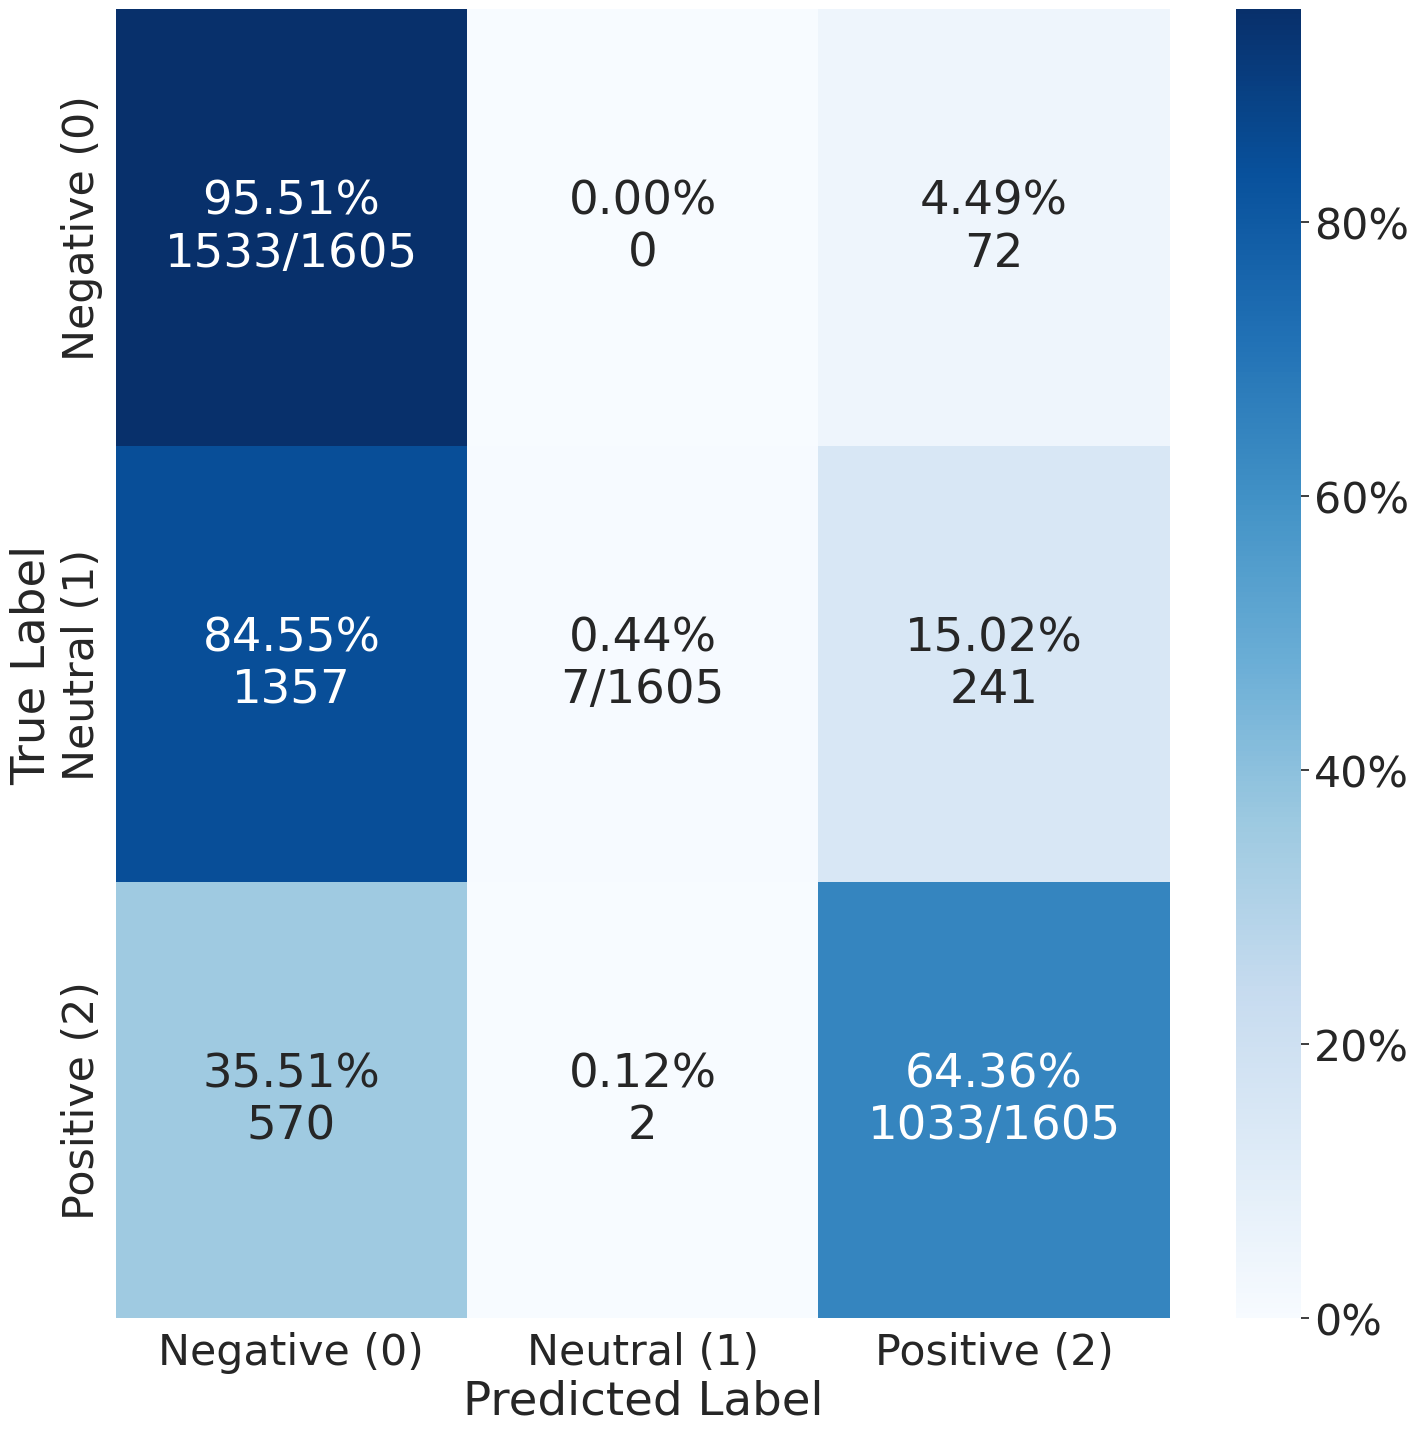

In [43]:
cm_analysis(true_labels, predicted_labels, 'confusion_matrix_BERTs', unique_labels, classes)

In [44]:
# Evaluate the model
results = trainer.evaluate()

/home/patrick.araujo/miniconda3/envs/llama/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [45]:
results

{'eval_loss': 1.7689800262451172,
 'eval_accuracy': 0.5343717549325026,
 'eval_precision': 0.6627668332600094,
 'eval_recall': 0.5343717549325026,
 'eval_f1': 0.438035487651146,
 'eval_mae': 0.5989615784008308,
 'eval_class_0_accuracy': 0.9551401869158879,
 'eval_class_0_precision': 0.4430635838150289,
 'eval_class_0_recall': 0.9551401869158879,
 'eval_class_0_f1': 0.6053307008884502,
 'eval_class_0_support': 1605,
 'eval_class_1_accuracy': 0.004361370716510903,
 'eval_class_1_precision': 0.7777777777777778,
 'eval_class_1_recall': 0.004361370716510903,
 'eval_class_1_f1': 0.008674101610904586,
 'eval_class_1_support': 1605,
 'eval_class_2_accuracy': 0.643613707165109,
 'eval_class_2_precision': 0.7674591381872214,
 'eval_class_2_recall': 0.643613707165109,
 'eval_class_2_f1': 0.7001016604540834,
 'eval_class_2_support': 1605,
 'eval_runtime': 19.4222,
 'eval_samples_per_second': 247.912,
 'eval_steps_per_second': 5.2,
 'epoch': 5.0}

In [46]:
output_file_path = './bert-base-uncased_sentiment_model'
destination = path+output_file_path

# Save the model
model.save_pretrained(destination)